## Example Experiment ##
### Dataset: Labeled Faces in the Wild ###
### Experiment: Two party training for gender classification ###

In [1]:
import simulator.server as server
import simulator.workerclass as worker
import simulator.workerhandler as wh
import topology_utils as tu

from collections import OrderedDict
import pandas as pd
import numpy as np
import copy
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sattvik/envs/pytorch_env/lib/py

## Parameters ##

In [2]:
epochs = 10
# epochs = 2
batch_size = 64
learning_rate = 0.001
server_learning_rate = 0.01
num_workers = 2
local_iterations = 2

data_path = '../data/lfw/data/'

# default `log_dir` is "runs" - we'll be more specific here
!rm -rf ./runs/experiment_2
writer = SummaryWriter('runs/experiment_2')

## Divide Data between workers ##

In [3]:
attributes_df = pd.read_csv(data_path+'lfw_attributes.txt')

all_names = attributes_df.person.unique()
tt_msk = np.random.rand(len(all_names)) < 0.8
temp_train_names = all_names[tt_msk]
test_names = all_names[~tt_msk]
del all_names, tt_msk
train_val_df = attributes_df.loc[attributes_df['person'].isin(temp_train_names)]
test_df = attributes_df.loc[attributes_df['person'].isin(test_names)]

# add column to indicate split
train_val_df['target'] = 0
# allocate half the people to the target
names = train_val_df['person'].drop_duplicates()
target_worker_names = names.sample(frac=1)[:int(len(names)/2)]
target_worker_names = target_worker_names.reset_index(drop=True)

# populate target field
for index, row in train_val_df.iterrows():
    if row['person'] in target_worker_names.values:
        train_val_df['target'][index] = 1

# print distribution of data
print("entries with worker 1: {}, entries with worker 2: {}, entries in training set: {}, total entries: {}".format(sum(train_val_df['target']==1), sum(train_val_df['target']==0), len(test_df), len(attributes_df)))

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

entries with worker 1: 5898, entries with worker 2: 5038, entries in training set: 2207, total entries: 13143


## Define dataset class ##

In [4]:
class LFWDataset(Dataset):
    """LFW dataset."""

    def __init__(self, data_path, attributes_df, transform=None):
        self.attributes_df = attributes_df
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.attributes_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, "lfw_home/lfw_funneled", self.attributes_df.iloc[idx]['person'].replace(' ', '_'),"{}_{:04d}.jpg".format(self.attributes_df.iloc[idx]['person'].replace(' ', '_'),self.attributes_df.iloc[idx]['imagenum']))
#         img = torch.from_numpy(cv2.imread(img_path))
        img = Image.open(img_path, mode='r')
        
        label = self.attributes_df.iloc[idx]['Male']>0
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float)

## Define Model ##

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.rnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet50', pretrained=True)
        self.rnet.fc = nn.Linear(2048, 1)
        
        for p in self.parameters():
            p.requires_grad = False

        for p in self.rnet.fc.parameters():
            p.requires_grad = True

    def forward(self, x):
        x = torch.sigmoid(self.rnet(x))
        return x
    
    def unfreeze_layer4(self):
        for p in self.rnet.layer4.parameters():
            p.requires_grad = True

    def unfreeze_layer3(self):
        for p in self.rnet.layer3.parameters():
            p.requires_grad = True

    def unfreeze_layer2(self):
        for p in self.rnet.layer2.parameters():
            p.requires_grad = True

    def unfreeze_layer1(self):
        for p in self.rnet.layer1.parameters():
            p.requires_grad = True

def define_model():
    return ResNet()

## Training, Validation, and Evaluation functions ##

In [6]:
def perform_evaluation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("testing loss: {} and testing accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [7]:
def perform_validation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
#             print(output, target.unsqueeze(1))
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("val loss: {} and val accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [8]:
def perform_training(val_model, dataloader, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
        # move data batch to GPU
        data = data.cuda()
        target = target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = val_model(data)
        loss = F.binary_cross_entropy(output, target.unsqueeze(1))
        # backward pass
        loss.backward()
        optimizer.step()
        # compute average loss an accuracy
        output = output.to('cpu')
        target = target.to('cpu')
        current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
        epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
        epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("train loss: {} and train accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

## Declare genuine worker ##

In [9]:
class target_worker(worker.base_workerclass):
    def __init__(self, name, attributes_df, model):
        super().__init__(name, False)
        self.worker_attributes_df = attributes_df[attributes_df['target']==1]
        print("initializing genuine worker node with ",len(self.worker_attributes_df)," data points")
        self.model = model
        self.local_iters = local_iterations
        # train val split
        all_names = self.worker_attributes_df.person.unique()
        tt_msk = np.random.rand(len(all_names)) < 0.8
        train_names = all_names[tt_msk]
        val_names = all_names[~tt_msk]
        del all_names, tt_msk
        
        # set optimizer
        self.set_optim()
        # create train val and test dataframes
        train_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(train_names)]
        val_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(val_names)]
        
        train_dataset = LFWDataset(data_path, train_df, transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
        val_dataset = LFWDataset(data_path, val_df, transform=transforms.Compose([
                                                            transforms.RandomResizedCrop(224),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor()]))
        del train_df, val_df
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        print(len(self.train_dataloader), len(self.val_dataloader))
    
    def set_param(self, w):
        self.model.load_state_dict(w)
    
    def get_params(self):
        return self.model.state_dict()
    
    def set_optim(self):
        self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def client_update(self, global_epoch):
        global writer
        self.model = self.model.cuda()
        prev_w = copy.deepcopy(self.model.state_dict())
        # unfreeze layers
        if 5 == global_epoch:
            self.model.unfreeze_layer3()
        if 20 == global_epoch:
            self.model.unfreeze_layer2()
        if 50 == global_epoch:
            self.model.unfreeze_layer1()
        for epoch in range(self.local_iters):
            # run train and val epochs
            print("sub-epoch: {}".format(epoch))
            self.model.train()
            train_loss, train_acc = perform_training(self.model, self.train_dataloader, self.optim)
            writer.add_scalar('training loss_'+self.name, train_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('training accuracy_'+self.name, train_acc, (global_epoch*self.local_iters)+epoch)
            self.model.eval()
            val_loss, val_acc = perform_validation(self.model, self.val_dataloader)
            writer.add_scalar('validation loss_'+self.name, val_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('validation accuracy_'+self.name, val_acc, (global_epoch*self.local_iters)+epoch)
        graddif = OrderedDict()
        for (item1, item2) in zip(self.model.state_dict().items(),prev_w.items()):
            key1=item1[0]
            value1=item1[1]
            key2=item2[0]
            value2=item2[1]
            diffval = value1-value2
            graddif.update({key1:diffval.cpu()})
        self.model = self.model.cpu()
        return graddif

## Declare malicious worker ##

In [10]:
# class malicious_worker(worker.base_workerclass):
#     def __init__(self, attributes_df, model):
#         super().__init__(True)
#         self.worker_attributes_df = attributes_df[attributes_df['target']==0]
#         print("initializing malicious worker node with ",len(self.worker_attributes_df)," data points")
#         self.model = model
#         self.local_iters = 5
    
#     def set_param(self, w):
#         self.model.load_state_dict(w)
    
#     def set_optim(self):
#         self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
#     def client_update(self):
#         print('ss')

## Initialize components of our simulations ##

In [11]:
server1 = server.server(server_learning_rate)
workers = wh.workerhandler([target_worker("w1", train_val_df,define_model()),target_worker("w2", train_val_df,define_model())])

Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


initializing genuine worker node with  5898  data points
69 24


Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


initializing genuine worker node with  5898  data points
76 17


In [12]:
tm = tu.topology_manager()

## Define network topology ##

In [13]:
tm.connect_star(server1, workers.get_all_workers())

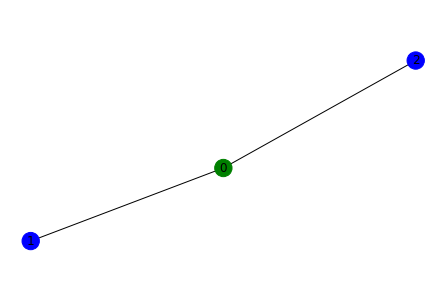

In [14]:
plot = tm.plot_topology()

## Start Training ##

In [15]:
# initialize server weights as model average
server1.set_init_weights(workers.get_average_weights())

# start training
for epoch in range(epochs):
    print("Epoch: ", epoch)
    new_grad = workers.perform_updates(epoch)
    new_w = server1.aggregate(new_grad)
    workers.set_param(new_w)

Epoch:  0
training on worker:  w1
sub-epoch: 0


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train loss: 0.44969159775022144 and train accuracy: 0.8055253624916077


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



val loss: 0.3194481326888005 and val accuracy: 0.9002700621883074
sub-epoch: 1



train loss: 0.3510715667752252 and train accuracy: 0.8658514489298281



val loss: 0.27820089831948286 and val accuracy: 0.9023919751246771
training on worker:  w2
sub-epoch: 0



train loss: 0.41433147733148773 and train accuracy: 0.8317991299064535



val loss: 0.3848068083033842 and val accuracy: 0.832827462869532
sub-epoch: 1



train loss: 0.31358100669948674 and train accuracy: 0.8809091150760651



val loss: 0.3243452117723577 and val accuracy: 0.865851574084338
Epoch:  1
training on worker:  w1
sub-epoch: 0



train loss: 0.4284131691075753 and train accuracy: 0.825317028639973



val loss: 0.2904696501791478 and val accuracy: 0.8849344129363695
sub-epoch: 1



train loss: 0.32530621493208245 and train accuracy: 0.8737771735675093



val loss: 0.27705401306351024 and val accuracy: 0.9117476840813955
training on worker:  w2
sub-epoch: 0



train loss: 0.4005924463272095 and train accuracy: 0.8350090196258144



val loss: 0.34364692779148326 and val accuracy: 0.8763893632327809
sub-epoch: 1



train loss: 0.29993271474775507 and train accuracy: 0.8885292865728077



val loss: 0.3774190685328315 and val accuracy: 0.8497563284986159
Epoch:  2
training on worker:  w1
sub-epoch: 0



train loss: 0.4260396251211996 and train accuracy: 0.824592391649882



val loss: 0.2984737101942301 and val accuracy: 0.8816068669160207
sub-epoch: 1



train loss: 0.33720434316690423 and train accuracy: 0.872554347998854



val loss: 0.2685790254424015 and val accuracy: 0.9069492667913437
training on worker:  w2
sub-epoch: 0



train loss: 0.3923883271452627 and train accuracy: 0.8434913519181704



val loss: 0.371140041772057 and val accuracy: 0.8355848158107084
sub-epoch: 1



train loss: 0.30211214132999126 and train accuracy: 0.8842383803505647



val loss: 0.3170065923648722 and val accuracy: 0.8860721623196322
Epoch:  3
training on worker:  w1
sub-epoch: 0



train loss: 0.44210556279058033 and train accuracy: 0.821693840234176



val loss: 0.3031509773184856 and val accuracy: 0.8892505789796511
sub-epoch: 1



train loss: 0.3336334440155306 and train accuracy: 0.8717391300892484



val loss: 0.2722489517182112 and val accuracy: 0.90386284639438
training on worker:  w2
sub-epoch: 0



train loss: 0.4058786183595657 and train accuracy: 0.8410109822687349



val loss: 0.3489885628223419 and val accuracy: 0.8745938784935895
sub-epoch: 1



train loss: 0.3107664053769489 and train accuracy: 0.8815391549938604



val loss: 0.3358896173098508 and val accuracy: 0.8672195637927336
Epoch:  4
training on worker:  w1
sub-epoch: 0



train loss: 0.4234248071477033 and train accuracy: 0.8259963764660601



val loss: 0.32327395863831043 and val accuracy: 0.8613040124376615
sub-epoch: 1



train loss: 0.33939880132675165 and train accuracy: 0.8646286233611729



val loss: 0.2730594538152218 and val accuracy: 0.9054060578346252
training on worker:  w2
sub-epoch: 0



train loss: 0.4038427548581048 and train accuracy: 0.8362956282339599



val loss: 0.3652310073375702 and val accuracy: 0.8613201099283555
sub-epoch: 1



train loss: 0.3108473794632836 and train accuracy: 0.8862279818246239



val loss: 0.3371204383233014 and val accuracy: 0.8695494181969586
Epoch:  5
training on worker:  w1
sub-epoch: 0



train loss: 0.3611236970493759 and train accuracy: 0.8589673914771149



val loss: 0.39425883380075294 and val accuracy: 0.8590615366895994
sub-epoch: 1



train loss: 0.276010019407756 and train accuracy: 0.8983242753623188



val loss: 0.22225510080655417 and val accuracy: 0.9274209116895994
training on worker:  w2
sub-epoch: 0



train loss: 0.33568784633749416 and train accuracy: 0.8663120756023809



val loss: 0.5369525516734404 and val accuracy: 0.7799888849258423
sub-epoch: 1



train loss: 0.25911884813716535 and train accuracy: 0.9031528540347752



val loss: 0.27920396363033967 and val accuracy: 0.8865637814297396
Epoch:  6
training on worker:  w1
sub-epoch: 0



train loss: 0.3669552307413972 and train accuracy: 0.8512228260869565



val loss: 0.36308303599556285 and val accuracy: 0.8960021212697029
sub-epoch: 1



train loss: 0.2823926219041798 and train accuracy: 0.8946557969286821



val loss: 0.2256515889118115 and val accuracy: 0.9122781629363695
training on worker:  w2
sub-epoch: 0



train loss: 0.34948871912140594 and train accuracy: 0.8608008803505647



val loss: 0.3191672344418133 and val accuracy: 0.8718792761073393
sub-epoch: 1



train loss: 0.26504140876625715 and train accuracy: 0.9000689724558278



val loss: 0.297880892367924 and val accuracy: 0.8907104976036969
Epoch:  7
training on worker:  w1
sub-epoch: 0



train loss: 0.37682625176250073 and train accuracy: 0.8442481885785642



val loss: 0.5863364549974599 and val accuracy: 0.7175925920406976
sub-epoch: 1



train loss: 0.28910802131977625 and train accuracy: 0.8902173914771149



val loss: 0.21563613694161177 and val accuracy: 0.9268904328346252
training on worker:  w2
sub-epoch: 0



train loss: 0.34721916227748517 and train accuracy: 0.8611590085845244



val loss: 0.37277278742369485 and val accuracy: 0.8258806431994719
sub-epoch: 1



train loss: 0.26027972113929304 and train accuracy: 0.9037563667485589



val loss: 0.272857385523179 and val accuracy: 0.9030651520280277
Epoch:  8
training on worker:  w1
sub-epoch: 0



train loss: 0.38078531320544257 and train accuracy: 0.8436594199443209



val loss: 0.2897270793716113 and val accuracy: 0.8974247674147288
sub-epoch: 1



train loss: 0.2774402825296789 and train accuracy: 0.8912590577982474



val loss: 0.23456947691738605 and val accuracy: 0.9165461038549741
training on worker:  w2
sub-epoch: 0



train loss: 0.34484655076735904 and train accuracy: 0.8603233765614661



val loss: 0.3729118880103616 and val accuracy: 0.8397101584602805
sub-epoch: 1



train loss: 0.2649900496594216 and train accuracy: 0.904565470783334



val loss: 0.3024776192272411 and val accuracy: 0.8943442211431616
Epoch:  9
training on worker:  w1
sub-epoch: 0



train loss: 0.39069063421608746 and train accuracy: 0.8416213764660601



val loss: 0.8118852972984314 and val accuracy: 0.6724295914173126
sub-epoch: 1



train loss: 0.2933479368254758 and train accuracy: 0.887092391649882



val loss: 0.23715446082254252 and val accuracy: 0.9241174757480621
training on worker:  w2
sub-epoch: 0



train loss: 0.3603225987600653 and train accuracy: 0.8558136138476824



val loss: 0.9002303691471324 and val accuracy: 0.5741920330945183
sub-epoch: 1



train loss: 0.2570927768553558 and train accuracy: 0.9000291808655387



val loss: 0.31181783535901236 and val accuracy: 0.8924632352941176


## Evaluate Model ##

In [16]:
# evaluate final model
eval_model = define_model()
eval_model.load_state_dict(new_w)
eval_model.eval()
eval_model = eval_model.cuda()
torch.save(eval_model.state_dict(), "models/experiment2_model.pt")

test_dataset = LFWDataset(data_path, test_df, transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loss, test_acc = perform_evaluation(eval_model, test_dataloader)

Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app



testing loss: 0.7018829260553633 and testing accuracy: 0.26487615193639485
